In [1]:
from TMfunctions import *
import pandas as pd
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

C:\Users\david\AppData\Local\Temp\ipykernel_22932\984142669.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Removing rare words

In [3]:
train = pd.read_csv('Data/StopWords/train.csv')
test = pd.read_csv('Data/StopWords/test.csv')

In [4]:
text = ' '.join(list(train['medical_abstract']))

In [5]:
words = text.split(" ")
frequency = {word:words.count(word) for word in set(words)}

In [6]:
sort = list(frequency.values())

In [7]:
sort.sort()

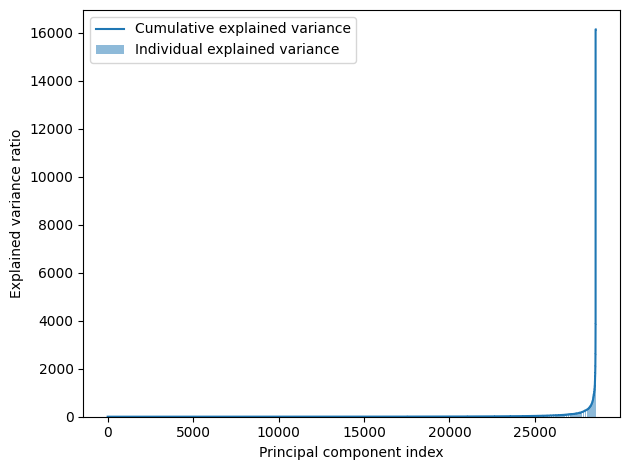

In [8]:
plt.bar(range(0,len(frequency)), sort, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(frequency)), sort, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [9]:
len(sort)

28559

In [10]:
len([x for x in sort if x < 2])

8508

In [11]:
len([x for x in sort if x < 5])

16309

In [12]:
len([x for x in sort if x < 10])

20601

In [13]:
len([x for x in sort if x < 20])

23421

In [14]:
new_stopwords = [i for i in frequency if frequency[i] < 2]

In [15]:
def remove(text):
    words = text.split(' ')
    words = [word for word in words if word not in new_stopwords]
    return ' '.join(words)

In [16]:
train['medical_abstract'] = train['medical_abstract'].apply(lambda x: remove(x))
test['medical_abstract'] = test['medical_abstract'].apply(lambda x: remove(x))

In [17]:
data = pd.concat([train, test])

In [18]:
data.to_csv('Data/RareWordsRemoval.csv')

In [3]:
data = pd.read_csv('Data/RareWordsRemoval.csv')

### Classification

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold

In [ ]:
kf = KFold(n_splits=5)

fold = 0

cv = CountVectorizer(min_df=0., max_df=1.)
Kresults = []

for train_index, test_index in kf.split(data):
    fold += 1
    if fold != 1:
        continue
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
    cv_matrix = cv.fit_transform(train['medical_abstract'])
    FE_train = cv_matrix.toarray()
    cv_matrix =  cv.transform(test['medical_abstract'])
    FE_test = cv_matrix.toarray()
    
    Kresult = micro_f1SVM(build_resultsSVM(FE_train, FE_test, train, test))
    Kresults.append(Kresult)
    print("fold " + str(fold) + ":")
    print(Kresult)
    print(" ")
    
    DT, RF, NB, SVM = 0, 0, 0, 0
    for result in Kresults:
        DT += result['DT']
        RF += result['RF']
        NB += result['NB']
        SVM += result['SVM']
    result = {'DT': DT/5, 'RF': RF/5, 'NB': NB/5, 'SVM': SVM/5}

In [6]:
Kresults = [
    {'DT': 0.66, 'RF': 0.683, 'NB': 0.55, 'SVM': 0.652},
    {'DT': 0.659, 'RF': 0.68, 'NB': 0.548, 'SVM': 0.648},
    {'DT': 0.675, 'RF': 0.682, 'NB': 0.546, 'SVM': 0.655},
    {'DT': 0.652, 'RF': 0.686, 'NB': 0.552, 'SVM': 0.641},
    {'DT': 0.664, 'RF': 0.683, 'NB': 0.548, 'SVM': 0.64}
]
DT, RF, NB, SVM = 0, 0, 0, 0
for result in Kresults:
    DT += result['DT']
    RF += result['RF']
    NB += result['NB']
    SVM += result['SVM']
result = {'DT': DT/5, 'RF': RF/5, 'NB': NB/5, 'SVM': SVM/5}

In [9]:
print(result)

{'DT': 0.662, 'RF': 0.6828, 'NB': 0.5488000000000001, 'SVM': 0.6472}


### Times

In [28]:
DT/2/60

16.029375578959783

In [29]:
RF/2/60

8.078622951110203

In [30]:
NB/2/60

0.40687843362490334

In [31]:
SVM/2/60

129.92606166402499

# StopWords Removal + TF-IDF

In [2]:
# Read train and test data
train = pd.read_csv('Data/StopWords/train.csv', index_col=0)
test = pd.read_csv('Data/StopWords/test.csv', index_col=0)

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(train['medical_abstract'])
FE_train = tfidf_matrix.toarray()

In [4]:
tfidf_matrix =  tfidf.transform(test['medical_abstract'])
FE_test = tfidf_matrix.toarray()

## Feature Selection: PCA

In [6]:
from sklearn.decomposition import PCA

pca = PCA()
X_transformed = pca.fit_transform(FE_train)

In [9]:
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

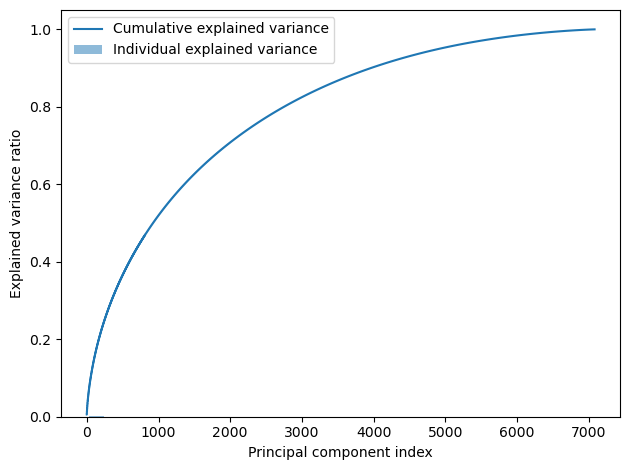

In [10]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [12]:
Y_transformed = pca.transform(FE_test)

In [14]:
FE_train = pd.DataFrame(X_transformed).iloc[: , :3000]
FE_test = pd.DataFrame(Y_transformed).iloc[: , :3000]

### Classification

In [15]:
results = build_results(FE_train, FE_test, train, test)

DT done
RF done
NB done
DT done
RF done
NB done
DT done
RF done
NB done
DT done
RF done
NB done
DT done
RF done
NB done


In [16]:
results.to_csv('Results/stopwords&tfidf&pca.csv')

In [17]:
micro_f1(results)

{'DT': 0.562, 'RF': 0.19, 'NB': 0.342}

In [18]:
macro_f1(results)

{'DT': 0.54, 'RF': 0.157, 'NB': 0.248}